<a href="https://colab.research.google.com/github/ssnyu/APM/blob/main/1_MonteCarloSimulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and Importing dependencies

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd

symbols = ["VTI", "VEU", "IEF", "VNQ"]

data = yf.download(symbols, start="2023-01-01", end="2024-02-05")["Close"]

[*********************100%%**********************]  4 of 4 completed


In [ ]:
data

Ticker,IEF,VEU,VNQ,VTI
Date,,,,
2023-01-03,96.529999,50.500000,82.559998,190.410004
2023-01-04,97.269997,51.369999,84.430000,192.100006
2023-01-05,97.129997,50.930000,82.160004,189.850006
2023-01-06,98.379997,52.180000,84.370003,194.039993
2023-01-09,98.629997,52.450001,84.400002,194.119995
...,...,...,...,...
2024-01-29,95.529999,55.720001,85.500000,244.320007
2024-01-30,95.660004,55.509998,84.699997,243.979996
2024-01-31,96.459999,55.209999,83.889999,239.869995


## Monte Carlo Simulation

In [ ]:
import numpy as np
from scipy.stats import norm
import timeit

# Set seed
np.random.seed(1121)

# Sample from Standard Normal Distribution
nrows = 1000
datav = np.random.normal(size=nrows)

# Sample mean - MC estimate
mean_estimate = np.mean(datav)
print("Sample Mean (Monte Carlo estimate):", mean_estimate)

# Sample standard deviation - MC estimate
sd_estimate = np.std(datav)
print("Sample Standard Deviation (Monte Carlo estimate):", sd_estimate)

# Monte Carlo estimate of cumulative probability
cumulative_prob_estimate = np.sum(datav < -2) / nrows
print("Monte Carlo estimate of cumulative probability:", cumulative_prob_estimate)

# Monte Carlo estimate of quantile
confl = 0.02
exact_quantile = norm.ppf(confl)
print("Exact quantile value:", exact_quantile)

cutoff = int(confl * nrows)
datav_sorted = np.sort(datav)
naive_quantile_estimate = datav_sorted[cutoff]
print("Naive Monte Carlo quantile value:", naive_quantile_estimate)

# Microbenchmark quantile
def monte_carlo_quantile():
    return datav_sorted[cutoff]

def scipy_quantile():
    return np.percentile(datav, confl * 100)

# Time the functions using timeit
monte_carlo_time = timeit.timeit(monte_carlo_quantile, number=100)
scipy_quantile_time = timeit.timeit(scipy_quantile, number=100)

print("\nMicrobenchmark Summary:")
print("Monte Carlo Quantile Time:", monte_carlo_time)
print("Scipy Quantile Time:", scipy_quantile_time)

Sample Mean (Monte Carlo estimate): -0.03994412924814993
Sample Standard Deviation (Monte Carlo estimate): 1.061745091107765
Monte Carlo estimate of cumulative probability: 0.031
Exact quantile value: -2.053748910631823
Naive Monte Carlo quantile value: -2.1157898784711504

Microbenchmark Summary:
Monte Carlo Quantile Time: 3.804100015258882e-05
Scipy Quantile Time: 0.0215282379999735


## Boostrap Estimator for errors

In [ ]:
import numpy as np
from scipy.stats import norm

# Sample from Standard Normal Distribution
nrows = 1000
datav = np.random.normal(size=nrows)

# Sample mean and standard deviation
sample_mean = np.mean(datav)
sample_sd = np.std(datav)

print("Sample Mean:", sample_mean)
print("Sample Standard Deviation:", sample_sd)

# Bootstrap of sample mean and median
nboot = 10000
bootd = np.array([np.random.normal(size=nrows) for _ in range(nboot)])
bootd_means = np.mean(bootd, axis=1)
bootd_medians = np.median(bootd, axis=1)

# Display a subset of the bootstrap results
print("Bootstrap Mean and Median (Subset):")
print(np.column_stack((bootd_means[:3], bootd_medians[:3])))

# Standard error from formula
se_formula = sample_sd / np.sqrt(nrows)
print("Standard Error from Formula:", se_formula)

# Standard error of mean from bootstrap
se_bootstrap_mean = np.std(bootd_means)
print("Standard Error of Mean from Bootstrap:", se_bootstrap_mean)

# Standard error of median from bootstrap
se_bootstrap_median = np.std(bootd_medians)
print("Standard Error of Median from Bootstrap:", se_bootstrap_median)

Sample Mean: -0.01659542175263764
Sample Standard Deviation: 1.0264065861141272
Bootstrap Mean and Median (Subset):
[[ 0.0447398   0.09149041]
 [-0.00883965  0.02640746]
 [-0.01795765 -0.02035139]]
Standard Error from Formula: 0.03245782617518396
Standard Error of Mean from Bootstrap: 0.03171487340325531
Standard Error of Median from Bootstrap: 0.039165155342151474


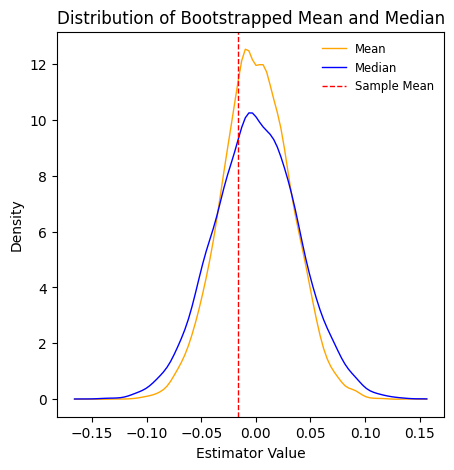

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Plot the densities of the bootstrap data
plt.figure(figsize=(5, 5))

# Compute kernel density estimates
kde_mean = gaussian_kde(bootd_means)
kde_median = gaussian_kde(bootd_medians)

# Values for x-axis
x_values = np.linspace(min(bootd_means.min(), bootd_medians.min()), max(bootd_means.max(), bootd_medians.max()), 100)

# Plot density for bootstrapped mean
plt.plot(x_values, kde_mean(x_values), label='Mean', linewidth=1, color='orange')

# Plot density for bootstrapped median
plt.plot(x_values, kde_median(x_values), label='Median', linewidth=1, color='blue')

# Vertical line for the sample mean
plt.axvline(sample_mean, linestyle='--', linewidth=1, color='red', label='Sample Mean')

# Set plot labels and title
plt.xlabel("Estimator Value")
plt.ylabel("Density")
plt.title("Distribution of Bootstrapped Mean and Median")

# Add legend
plt.legend(loc='upper right', fontsize='small', title=None, frameon=False)

# Show the plot
plt.show()

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import multiprocessing
import timeit

# Set seed
np.random.seed(1121)

# Sample from Standard Normal Distribution
nrows = 1000
datav = np.random.normal(size=nrows)

# Function to perform bootstrap for mean and median
def bootstrap_sample(x):
    samplev = np.random.normal(size=nrows)
    return np.array([np.mean(samplev), np.median(samplev)])

# Number of bootstrap samples
nboot = 10000

# Check if running on Windows
is_windows = False
try:
    import msvcrt
    is_windows = True
except ImportError:
    pass

# Parallelize bootstrap procedure based on the OS
if is_windows:
    # Use ProcessPoolExecutor for Windows
    with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count() - 1) as executor:
        bootd = list(executor.map(bootstrap_sample, range(1, nboot + 1)))
else:
    # Use ThreadPoolExecutor for Mac-OSX or Linux
    with ThreadPoolExecutor(max_workers=multiprocessing.cpu_count() - 1) as executor:
        bootd = list(executor.map(bootstrap_sample, range(1, nboot + 1)))

# Convert list of arrays to NumPy array
bootd = np.vstack(bootd)

# Means and standard errors from bootstrap
bootstrap_means_and_errors = np.apply_along_axis(lambda x: [np.mean(x), np.std(x)], axis=0, arr=bootd.T)

# Standard error from formula
se = np.std(datav) / np.sqrt(nrows)

# Display results
print("Means Standard Errors from Bootstrap:")
print(bootstrap_means_and_errors)
print("\nStandard Error:", se)

Means and Standard Errors from Bootstrap:
[[-0.00252077  0.0681151   0.00878391 ... -0.00436073 -0.02785692
  -0.02968841]
 [ 0.01407465  0.0233753   0.01762356 ...  0.00164983  0.0010221
   0.00938802]]

Standard Error: 0.03357532782403526
